# Examples

Here is a short guide to using carspy in a project:

## Setup

### Import necessary modules

In [1]:
import sys
sys.path.append('D:\\153_carspy')
from carspy import CarsSpectrum, CarsFit
from carspy.utils import downsample
from carspy.convol_fcn import asym_Gaussian

### Additional modules

`numpy` and `matplotlib` are also used in this demo.

In [2]:
import numpy as np
import matplotlib.pyplot as plt


## Synthesize CARS spectra

### Initialize the parameters

Following is the standard procedure to start syntheiszing a spectrum. By default, the set of nonresonant susceptibilities used is taken from CARSFT \[[Pal89](references)\] ("Set 1"). Details regarding the choices can be found in the [module documentation](cars_synth). Custom values can be used by modifying the following attributes:
 
- `.chi_nrs` (a dictionary of species names and nonresonant susceptiblities),
- `.chi_nrs_T0` (standard temperature for the susceptibilities),
- `.chi_nrs_P0` (standard pressure for the susceptibilities) 

In [3]:
# set the modes used to generate the spectrum
synth_mode = {'pump_ls': 'Gaussian',  # pump laser lineshape
              'chi_rs': 'G-matrix',   # solve G-matrix
              'convol': 'Kataoka',    # Kataoka convolution (convolve twice)
              'doppler_effect': True, # convolution with Doppler broadening
              'chem_eq': False}       # Not assume chemical equilibrium

# (optional) initial gas composition
init_comp = {'N2': 0.79,
             'Ar': 0.0,
             'CO2': 0,
             'CO': 0,
             'H2': 0,
             'O2': 0.21,
             'H2O': 0,
             'CH4': 0}

# initialize the spectrum
cars = CarsSpectrum(pressure=1, 
                    init_comp=init_comp,
                    chi_set="SET 1")


### Create the spectrum

Try varying the temperature and other parameters to see the changes in the CARS spectrum.


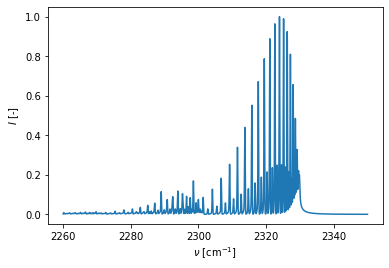

In [4]:
# define the spectral range
nu = np.linspace(2260, 2350, num=10000)
_, spect = cars.signal_as(temperature=1750,
                          nu_s=nu,
                          synth_mode=synth_mode,
                          pump_lw=0.2)

_, ax = plt.subplots(1)
ax.plot(nu, spect/spect.max())
ax.set_ylabel(r'$I$ [-]')
ax.set_xlabel(r'$\nu$ [cm$^{-1}$]')
plt.show()

### Apply a slit function

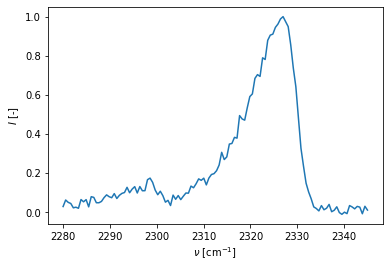

In [5]:
# create random noise
np.random.seed(42)
noise = np.random.rand(120)

# a mock slit function
slit_fcn = asym_Gaussian(nu, 1/2*(nu[0] + nu[-1]),
                         1.2, 1.2, 0.14, 0., 0)

# convolve the spectrum with the slit function
spect_conv = np.convolve(spect, slit_fcn, 'same')

# downsample a segment and add noise to synthesize an expt. spectrum
nu_expt = np.linspace(2280, 2345, num=120)
expt_spec = downsample(nu_expt, nu, spect_conv) + noise*8000 - 3000

_, ax = plt.subplots(1)
ax.plot(nu_expt, expt_spec/expt_spec.max())
ax.set_ylabel(r'$I$ [-]')
ax.set_xlabel(r'$\nu$ [cm$^{-1}$]')
plt.show()

## Fit CARS spectra

### Initialize the fit

In [8]:
modes = {'power_factor' : 0,         
        'downsample' : 'local_mean',
        'slit' : 'sGaussian',
        'pump_ls' : 'Gaussian',
        'chi_rs' : 'G-matrix',  
        'convol' : 'K',
        'doppler_effect' : False,
        'chem_eq' : False,
        'fit' : 'custom'}
    
fit_expt = CarsFit(expt_spec, nu_expt, fit_mode=modes, ref_fac=80)
fit_expt.preprocess()

### Control the fitting parameters

In [6]:
params = (('temperature', 2000, True, 250, 3000),
          ('del_Tv', 0, False, 0, 500),
          ('x_mol', 0.79, False, 0.2, 1.5),
          ('nu_shift', 0, True, -1, 1),
          ('nu_stretch', 1, False, 0.5, 1.5),
          ('pump_lw', 0.2, False, 0.1, 10),
          ('param1', 1.2, False),
          ('param2', 1.2, False),
          ('param3', 0.14, False),
          ('param4', 0, False))


### Perform the least-square fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 120
    # variables        = 2
    chi-square         = 0.03224835
    reduced chi-square = 2.7329e-04
    Akaike info crit   = -982.613607
    Bayesian info crit = -977.038623
[[Variables]]
    x_mol:        0.79 (fixed)
    temperature:  1769.73283 +/- 9.03331533 (0.51%) (init = 2000), model_value = 2000
    del_Tv:       0 (fixed)
    nu_shift:    -0.08680801 +/- 0.02522428 (29.06%) (init = 0), model_value = 0
    nu_stretch:   1 (fixed)
    pump_lw:      0.2 (fixed)
    param1:       1.2 (fixed)
    param2:       1.2 (fixed)
    param3:       0.14 (fixed)
    param4:       0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(temperature, nu_shift) = -0.477


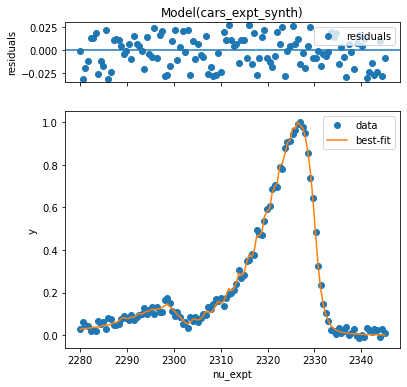

In [9]:
fit_expt.ls_fit(add_params=params, show_fit=True)